In [195]:

### System
import os
import joblib

### Set seed
import random
random.seed(42)

### Mains
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
%matplotlib inline 


# ### Models:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

### Ensemble Models:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier


### Dats Splits 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

### Pipelines
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.utils import shuffle

# # Sampling Methods
# from imblearn.over_sampling import SMOTE, RandomOverSampler
# from imblearn.under_sampling import NearMiss, RandomUnderSampler

### Metrics:
import sklearn.metrics as skm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [172]:
# df = pd.read_excel("data.csv.xlsx", sheet_name="train")
# df.to_pickle("data.pkl")

source = "data_with_distance.pkl" # includes distance_customer_merchant from geopy.distance
df = pd.read_pickle(source)

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181822 entries, 0 to 181821
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   transDate                   181822 non-null  datetime64[ns]
 1   creditCardNum               181822 non-null  int64         
 2   business                    181822 non-null  object        
 3   category                    181822 non-null  object        
 4   amount                      181822 non-null  float64       
 5   firstName                   181822 non-null  object        
 6   lastName                    181822 non-null  object        
 7   gender                      181822 non-null  object        
 8   street                      181822 non-null  object        
 9   city                        181822 non-null  object        
 10  state                       181822 non-null  object        
 11  zip                         181822 non-

In [174]:
df.head(3)

,transDate,creditCardNum,business,category,amount,firstName,lastName,gender,street,city,...,longitude,cityPop,job,dateOfBirth,transNum,unixTime,merchLatitude,merchLongitude,isFraud,distance_customer_merchant
0,2019-01-01 04:28:00,4119762878330980,fraud_Welch Inc,misc_net,4.10,Melinda,Gutierrez,F,1497 West Gateway,Eureka,...,-89.2706,6713,Archivist,1945-08-19,3fc1791ff1db94ce9540262d7eb973e4,1325392080,40.020043,-89.693412,0,85.14
1,2019-01-01 04:28:15,36078114201167,fraud_Auer-West,shopping_net,2.67,Christopher,Horn,M,956 Sanchez Highway,Mallie,...,-82.9161,798,Facilities manager,1926-06-26,edbf65b8606b53fc48168c2daa5933e5,1325392095,37.622362,-82.676007,0,44.58
2,2019-01-01 04:29:14,4449530933957320,fraud_Balistreri-Nader,misc_pos,22.88,Felicia,Mckee,F,84079 Thomas Burgs,Tomales,...,-122.9145,337,Occupational psychologist,1954-07-05,2fcbde131cff833751dde53da54da6da,1325392154,39.060101,-121.969417,0,122.48


### Drop non-useful feautures

In [175]:
df = df.drop(columns=[
    'unixTime', # error
    'creditCardNum'
    ])

transDate change to dayofyear

ie: 2019-01-01 04:28:00 ===> 1

In [176]:
df['transDate'] = pd.to_datetime(df['transDate'])
df['dateOfBirth'] = pd.to_datetime(df['dateOfBirth'])

df['trans_day'] =df['transDate'].dt.dayofyear
df['trans_weekday'] = df['transDate'].dt.weekday
df['trans_hour'] = df['transDate'].dt.hour
df['age_at_transaction'] = df['transDate'].dt.year - df['dateOfBirth'].dt.year


### Merchant distance in Km

> pip3 install geopy

No need to run. See distance.ipynb

In [177]:
# from geopy.distance import geodesic
# # https://pypi.org/project/geopy/#Measuring%20Distance
# def getDistance(row):
#     customer_loc = (row['latitude'], row['longitude'])
#     merchant_loc = (row['merchLatitude'], row['merchLongitude'])
#     return round(geodesic(customer_loc, merchant_loc).km, 2)

# print(getDistance(df.sample(1).iloc[0]))

### Apply to the entrire dataset
# df['distance_customer_merchant'] = df.apply(getDistance, axis=1)

In [178]:
print(df.shape)
df.head()

(181822, 25)


,transDate,business,category,amount,firstName,lastName,gender,street,city,state,...,dateOfBirth,transNum,merchLatitude,merchLongitude,isFraud,distance_customer_merchant,trans_day,trans_weekday,trans_hour,age_at_transaction
0,2019-01-01 04:28:00,fraud_Welch Inc,misc_net,4.10,Melinda,Gutierrez,F,1497 West Gateway,Eureka,IL,...,1945-08-19,3fc1791ff1db94ce9540262d7eb973e4,40.020043,-89.693412,0,85.14,1,1,4,74
1,2019-01-01 04:28:15,fraud_Auer-West,shopping_net,2.67,Christopher,Horn,M,956 Sanchez Highway,Mallie,KY,...,1926-06-26,edbf65b8606b53fc48168c2daa5933e5,37.622362,-82.676007,0,44.58,1,1,4,93
2,2019-01-01 04:29:14,fraud_Balistreri-Nader,misc_pos,22.88,Felicia,Mckee,F,84079 Thomas Burgs,Tomales,CA,...,1954-07-05,2fcbde131cff833751dde53da54da6da,39.060101,-121.969417,0,122.48,1,1,4,65
3,2019-01-01 04:29:18,"fraud_Boehm, Predovic and Reinger",misc_pos,9.59,Daniel,Cain,M,384 Newman Forks Apt. 370,Belmond,IA,...,1964-08-08,bcae564f9a1a299dfbd1efd917499968,43.280848,-94.340312,0,75.64,1,1,4,55
4,2019-01-01 04:32:09,fraud_Hudson-Ratke,grocery_pos,129.06,Theresa,Blackwell,F,43576 Kristina Islands,Shenandoah Junction,WV,...,1966-02-14,5e42e35c255edb55a192b3f1f0600936,39.211630,-78.409044,0,53.59,1,1,4,53


In [179]:
df = df.drop(columns=[
    'transNum', 
    'merchLatitude',
    'merchLongitude',
    'latitude',
    'longitude',
    'dateOfBirth',
    'transDate'
]
)

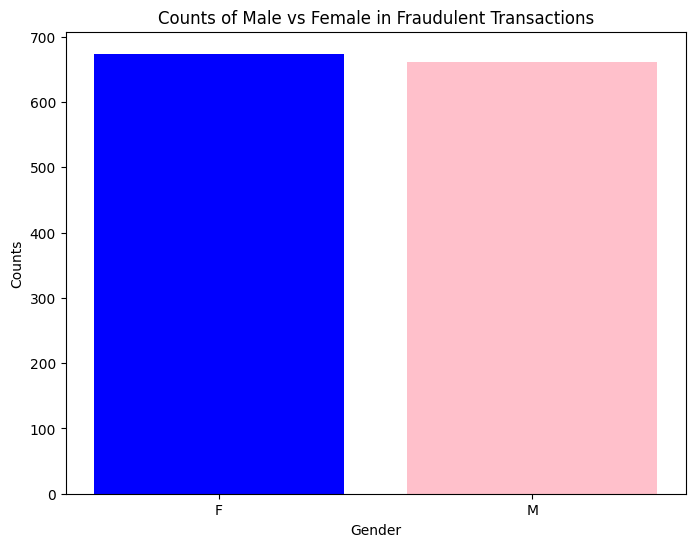

In [180]:
import matplotlib.pyplot as plt

fraud_df = df[df['isFraud'] == 1]
gender_counts = fraud_df['gender'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(gender_counts.index, gender_counts.values, color=['blue', 'pink'])
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Counts of Male vs Female in Fraudulent Transactions')
plt.show()


In [181]:
100*df.isFraud.value_counts(normalize=True)

isFraud
0    99.265215
1     0.734785
Name: proportion, dtype: float64

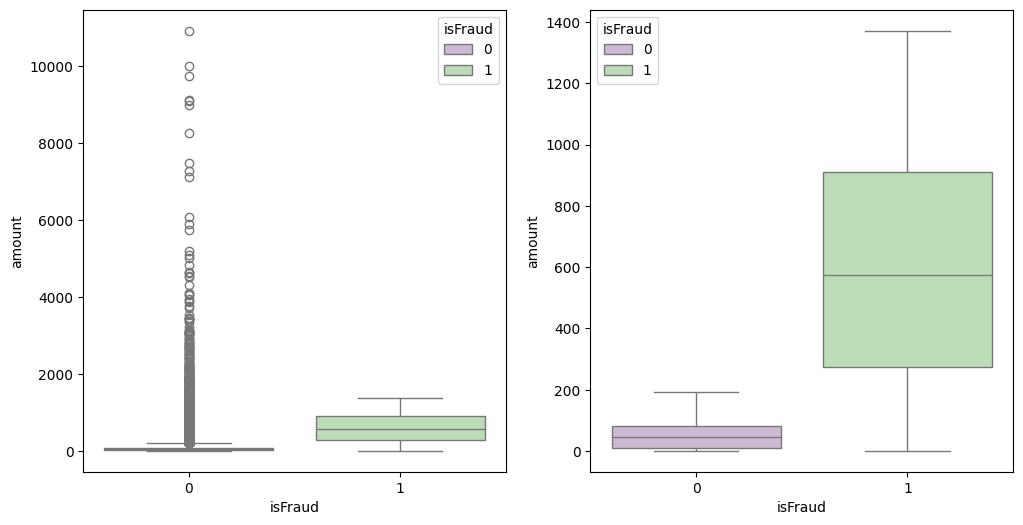

In [182]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="isFraud", y="amount", hue="isFraud",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="amount", hue="isFraud",data=df, palette="PRGn",showfliers=False)
plt.show();

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181822 entries, 0 to 181821
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   business                    181822 non-null  object 
 1   category                    181822 non-null  object 
 2   amount                      181822 non-null  float64
 3   firstName                   181822 non-null  object 
 4   lastName                    181822 non-null  object 
 5   gender                      181822 non-null  object 
 6   street                      181822 non-null  object 
 7   city                        181822 non-null  object 
 8   state                       181822 non-null  object 
 9   zip                         181822 non-null  int64  
 10  cityPop                     181822 non-null  int64  
 11  job                         181822 non-null  object 
 12  isFraud                     181822 non-null  int64  
 13  distance_custo

In [184]:
df['category'].unique()

array(['misc_net', 'shopping_net', 'misc_pos', 'grocery_pos',
       'entertainment', 'gas_transport', 'personal_care', 'shopping_pos',
       'food_dining', 'home', 'kids_pets', 'grocery_net',
       'health_fitness', 'travel'], dtype=object)

In [185]:
df.isnull().sum()   

business                      0
category                      0
amount                        0
firstName                     0
lastName                      0
gender                        0
street                        0
city                          0
state                         0
zip                           0
cityPop                       0
job                           0
isFraud                       0
distance_customer_merchant    0
trans_day                     0
trans_weekday                 0
trans_hour                    0
age_at_transaction            0
dtype: int64

In [186]:
df_train = df.drop(columns=[
    'business', 
    'firstName',
    'lastName',
    'gender',
    'street',
    'city',
    'zip',
    'job'
])

In [187]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181822 entries, 0 to 181821
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   category                    181822 non-null  object 
 1   amount                      181822 non-null  float64
 2   state                       181822 non-null  object 
 3   cityPop                     181822 non-null  int64  
 4   isFraud                     181822 non-null  int64  
 5   distance_customer_merchant  181822 non-null  float64
 6   trans_day                   181822 non-null  int32  
 7   trans_weekday               181822 non-null  int32  
 8   trans_hour                  181822 non-null  int32  
 9   age_at_transaction          181822 non-null  int32  
dtypes: float64(2), int32(4), int64(2), object(2)
memory usage: 11.1+ MB


In [188]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd
import numpy as np

# Initialize the OneHotEncoder and LabelEncoder
onehot_encoder = OneHotEncoder(sparse=False)  # Setting sparse=False ensures the output is a numpy array
label_encoder_state = LabelEncoder()

# Reshape the 'category' column to a 2D array as OneHotEncoder expects a 2D input
categories = df_train['category'].values.reshape(-1, 1)

# Fit and transform the 'category' column using OneHotEncoder
categories_encoded = onehot_encoder.fit_transform(categories)

# Convert the encoded categories back to a DataFrame
categories_encoded_df = pd.DataFrame(categories_encoded, columns=onehot_encoder.get_feature_names_out(['category']))

# Reset index on your original DataFrame if necessary to ensure indices align when concatenating
df_train.reset_index(drop=True, inplace=True)

# Concatenate the original DataFrame with the new one-hot encoded DataFrame
df_train_encoded = pd.concat([df_train, categories_encoded_df], axis=1)

# Drop the original 'category' column as it's now encoded
df_train_encoded.drop('category', axis=1, inplace=True)

# Fit and transform the 'state' column using LabelEncoder
df_train_encoded['state'] = label_encoder_state.fit_transform(df_train_encoded['state'])

# Check the first few rows to verify
print(df_train_encoded.head())

# Optional: Print the mapping for the 'state' column
state_mapping = dict(zip(label_encoder_state.classes_, label_encoder_state.transform(label_encoder_state.classes_)))
print("State Mapping:", state_mapping)


   amount  state  cityPop  isFraud  distance_customer_merchant  trans_day  \
0    4.10     13     6713        0                       85.14          1   
1    2.67     16      798        0                       44.58          1   
2   22.88      4      337        0                      122.48          1   
3    9.59     11     3032        0                       75.64          1   
4  129.06     48     1925        0                       53.59          1   

   trans_weekday  trans_hour  age_at_transaction  category_entertainment  ...  \
0              1           4                  74                     0.0  ...   
1              1           4                  93                     0.0  ...   
2              1           4                  65                     0.0  ...   
3              1           4                  55                     0.0  ...   
4              1           4                  53                     0.0  ...   

   category_grocery_pos  category_health_fitness  

/home/kayaba/.virtualenvs/ds/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [189]:
df_train_encoded.head()

,amount,state,cityPop,isFraud,distance_customer_merchant,trans_day,trans_weekday,trans_hour,age_at_transaction,category_entertainment,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,4.10,13,6713,0,85.14,1,1,4,74,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.67,16,798,0,44.58,1,1,4,93,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,22.88,4,337,0,122.48,1,1,4,65,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,9.59,11,3032,0,75.64,1,1,4,55,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,129.06,48,1925,0,53.59,1,1,4,53,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [190]:
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181822 entries, 0 to 181821
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   amount                      181822 non-null  float64
 1   state                       181822 non-null  int64  
 2   cityPop                     181822 non-null  int64  
 3   isFraud                     181822 non-null  int64  
 4   distance_customer_merchant  181822 non-null  float64
 5   trans_day                   181822 non-null  int32  
 6   trans_weekday               181822 non-null  int32  
 7   trans_hour                  181822 non-null  int32  
 8   age_at_transaction          181822 non-null  int32  
 9   category_entertainment      181822 non-null  float64
 10  category_food_dining        181822 non-null  float64
 11  category_gas_transport      181822 non-null  float64
 12  category_grocery_net        181822 non-null  float64
 13  category_groce

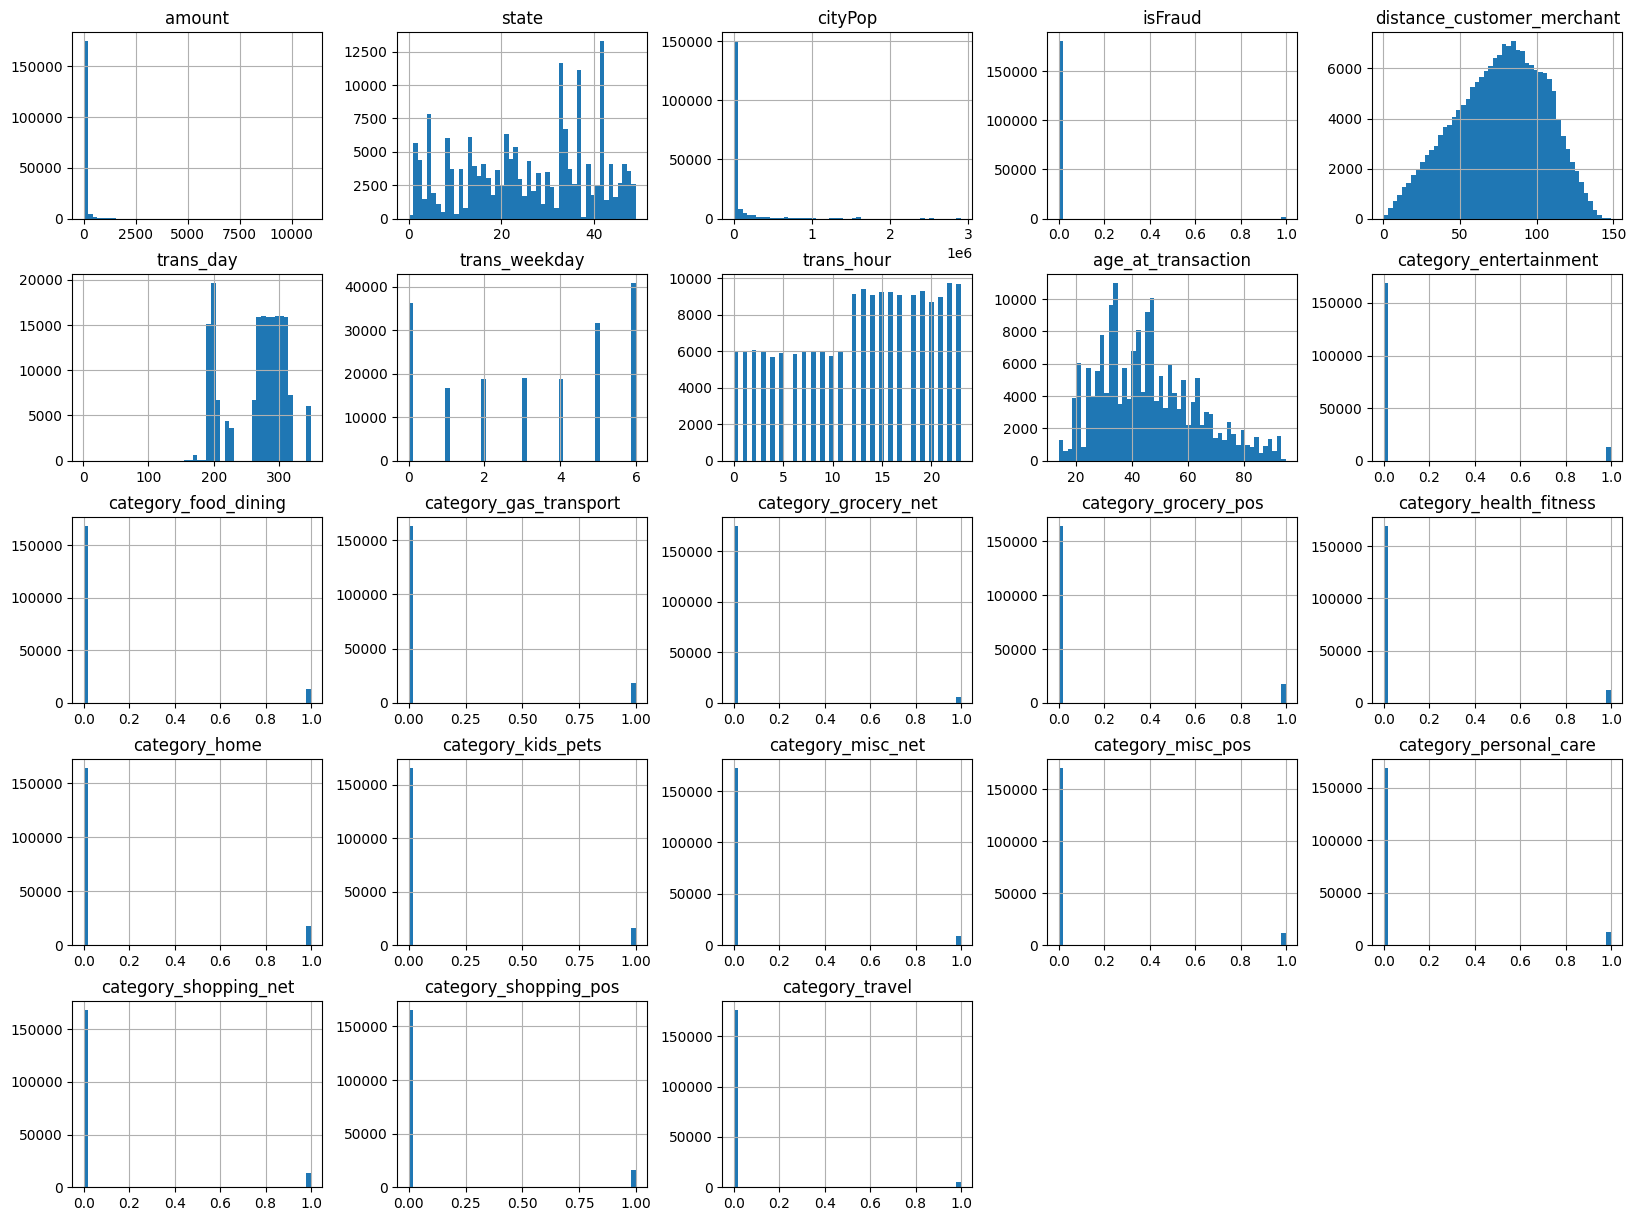

In [191]:
df_train_encoded.hist(bins=50, figsize=(20,15));

<Axes: >

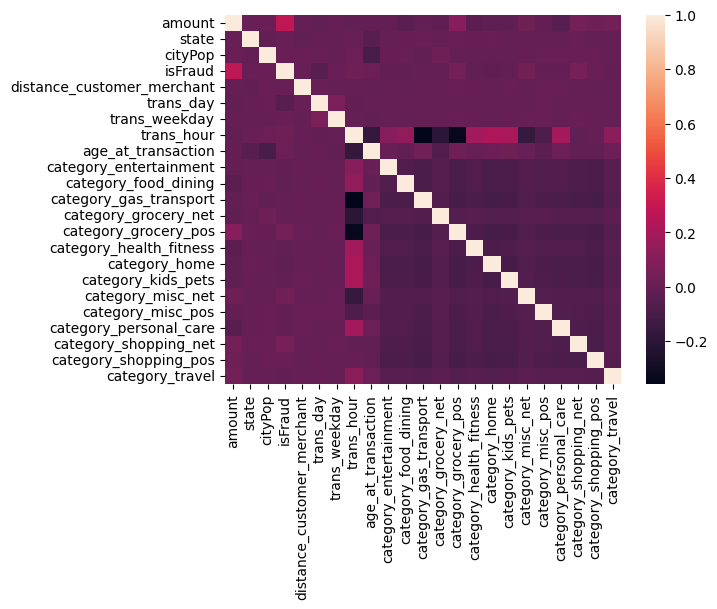

In [193]:
corr_matrix = df_train_encoded.corr()
sns.heatmap(corr_matrix)

In [194]:
corr_matrix["isFraud"].sort_values(ascending=False)

isFraud                       1.000000
amount                        0.282902
category_shopping_net         0.052611
category_grocery_pos          0.039221
category_misc_net             0.028487
trans_hour                    0.022698
age_at_transaction            0.013262
category_shopping_pos         0.011507
trans_weekday                 0.010622
cityPop                       0.009632
state                         0.006775
distance_customer_merchant    0.004222
category_gas_transport       -0.006114
category_grocery_net         -0.008503
category_travel              -0.009104
category_misc_pos            -0.009484
category_entertainment       -0.013400
category_personal_care       -0.014043
category_health_fitness      -0.016817
category_food_dining         -0.018768
category_kids_pets           -0.019225
category_home                -0.020704
trans_day                    -0.043228
Name: isFraud, dtype: float64

In [196]:
pipelines = {

    'LogisticRegression':make_pipeline(StandardScaler(), LogisticRegression()),
    'KNeighborsClassifier':make_pipeline(StandardScaler(), KNeighborsClassifier()),
    'RandomForestClassifier':make_pipeline(StandardScaler(), RandomForestClassifier()),
    #'RidgeClassifier':make_pipeline(StandardScaler(), RidgeClassifier()),
    'DecisionTreeClassifier':make_pipeline(StandardScaler(), DecisionTreeClassifier()),
    'GradientBoostingClassifier':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
}

In [197]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train_encoded.drop(columns=['isFraud']),
    df_train_encoded['isFraud'],
test_size=0.2)

X_train.shape, y_train.shape, X_train.values, y_train.values

((145457, 22),
 (145457,),
 array([[8.07000e+00, 4.90000e+01, 6.35000e+02, ..., 0.00000e+00,
         1.00000e+00, 0.00000e+00],
        [4.94000e+00, 2.40000e+01, 2.46450e+04, ..., 0.00000e+00,
         0.00000e+00, 1.00000e+00],
        [3.11200e+01, 1.00000e+00, 4.93806e+05, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        ...,
        [4.60000e+00, 2.60000e+01, 5.35400e+03, ..., 0.00000e+00,
         0.00000e+00, 1.00000e+00],
        [5.07000e+00, 3.30000e+01, 2.50470e+06, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [6.51300e+01, 4.20000e+01, 9.90000e+01, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00]]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [198]:
fit_models = {}
for algo, pipeline in pipelines.items():
    print(algo)
    model = pipeline.fit(X_train.values, y_train)
    fit_models[algo] = model

LogisticRegression
KNeighborsClassifier
RandomForestClassifier
RidgeClassifier
DecisionTreeClassifier
GradientBoostingClassifier


In [199]:
from sklearn.model_selection import cross_val_score

for name, model in fit_models.items():
    print(f'Model: {name}')
    for metric in ['precision', 'recall', 'f1']:
        scores = cross_val_score(model, X_test, y_test, cv=10, scoring=metric)
        mean_score = round(scores.mean() * 100, 2)
        print(f'--> {metric.capitalize()}: {mean_score}%')
    print('-' * 40)

Model: LogisticRegression
--> Precision: 62.38%
--> Recall: 15.88%
--> F1: 24.55%
----------------------------------------
Model: KNeighborsClassifier
--> Precision: 83.73%
--> Recall: 43.96%
--> F1: 57.53%
----------------------------------------
Model: RandomForestClassifier
--> Precision: 97.78%
--> Recall: 65.6%
--> F1: 78.67%
----------------------------------------
Model: RidgeClassifier


/home/kayaba/.virtualenvs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayaba/.virtualenvs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayaba/.virtualenvs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayaba/.virtualenvs/ds/lib/python3.10/site-packages/sklearn/metrics

--> Precision: 0.0%
--> Recall: 0.0%
--> F1: 0.0%
----------------------------------------
Model: DecisionTreeClassifier
--> Precision: 79.43%
--> Recall: 78.09%
--> F1: 77.62%
----------------------------------------
Model: GradientBoostingClassifier
--> Precision: 90.64%
--> Recall: 74.25%
--> F1: 81.69%
----------------------------------------


In [200]:
rtc = RandomForestClassifier(
    max_features=0.4,
    max_depth=None,
    min_samples_leaf=2,
    criterion='gini',
    random_state=42,
    n_estimators=1000,
    n_jobs=-1,
    )

rtc.fit(X_train, y_train)

y_pred = rtc.predict_proba(X_test)[:,1] >= 0.479
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


Accuracy: 0.9988450433108759
Precision: 0.9826086956521739
Recall: 0.8560606060606061
F1 Score: 0.9149797570850202
Confusion Matrix:
 [[36097     4]
 [   38   226]]


In [201]:
importance = rtc.feature_importances_

# Sort feature importance in descending order
sorted_importance = sorted(zip(importance, X_train.columns), reverse=True)

# Print feature importance in descending order
for i, f in enumerate(sorted_importance):
    print("{:2d}) {:<30} {:.2%}".format(i + 1, f[1], f[0]))

 1) amount                         42.70%
 2) trans_day                      15.13%
 3) trans_hour                     11.07%
 4) category_grocery_pos           8.41%
 5) age_at_transaction             5.27%
 6) trans_weekday                  3.42%
 7) cityPop                        2.98%
 8) category_gas_transport         2.70%
 9) distance_customer_merchant     2.23%
10) state                          1.54%
11) category_misc_pos              0.76%
12) category_misc_net              0.75%
13) category_shopping_net          0.73%
14) category_entertainment         0.56%
15) category_travel                0.55%
16) category_home                  0.45%
17) category_shopping_pos          0.33%
18) category_food_dining           0.11%
19) category_personal_care         0.10%
20) category_kids_pets             0.09%
21) category_health_fitness        0.07%
22) category_grocery_net           0.07%


### CHECK UNDERSMAPLING AND SMOTE, run again

In [ ]:
fraud = df[df.isFraud == 1]
normal = df[df.isFraud == 0]

print(f"Num Total txns: {df.shape[0]}")
print(f"Num fraud txns: {fraud.shape[0]}")
print(f"Num normal txns: {normal.shape[0]}")
print(f"% of fraud of all: {fraud.shape[0] / df.shape[0] * 100:.4f}%")


Num Total txns: 181822
Num fraud txns: 1336
Num normal txns: 180486
% of fraud of all: 0.7348%
